In [59]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
from astropy.io import fits
from scipy import stats
from sklearn.utils import check_random_state
import time as tm

import numpy as np


from scipy.fftpack import fft, ifft, fftshift



In [48]:

def FT_continuous(t, h, axis=-1, method=1):
    """Approximate a continuous 1D Fourier Transform with sampled data.

    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention

    .. math::

       H(f) = \int h(t) exp(-2 \pi i f t) dt

    It returns f and H, which approximate H(f).

    Parameters
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.

    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    H : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
    if N % 2 != 0:
        raise ValueError("number of samples must be even")

    Dt = t[1] - t[0]
    Df = 1. / (N * Dt)
    t0 = t[N // 2]

    f = Df * (np.arange(N) - N // 2)

    shape = np.ones(h.ndim, dtype=int)
    shape[axis] = N

    phase = np.ones(N)
    phase[1::2] = -1
    phase = phase.reshape(shape)

    if method == 1:
        H = Dt * fft(h * phase, axis=axis)
    else:
        H = Dt * fftshift(fft(h, axis=axis), axes=axis)

    H *= phase
    H *= np.exp(-2j * np.pi * t0 * f.reshape(shape))
    H *= np.exp(-1j * np.pi * N / 2)

    return f, H



def PSD_continuous(t, h, axis=-1, method=1):
    """Approximate a continuous 1D Power Spectral Density of sampled data.

    This function uses the Fast Fourier Transform to approximate
    the continuous fourier transform of a sampled function, using
    the convention

    .. math::

        H(f) = \int h(t) \exp(-2 \pi i f t) dt

    It returns f and PSD, which approximate PSD(f) where

    .. math::

        PSD(f) = |H(f)|^2 + |H(-f)|^2

    Parameters
    ----------
    t : array_like
        regularly sampled array of times
        t is assumed to be regularly spaced, i.e.
        t = t0 + Dt * np.arange(N)
    h : array_like
        real or complex signal at each time
    axis : int
        axis along which to perform fourier transform.
        This axis must be the same length as t.

    Returns
    -------
    f : ndarray
        frequencies of result.  Units are the same as 1/t
    PSD : ndarray
        Fourier coefficients at each frequency.
    """
    assert t.ndim == 1
    assert h.shape[axis] == t.shape[0]
    N = len(t)
    if N % 2 != 0:
        raise ValueError("number of samples must be even")

    ax = axis % h.ndim

    if method == 1:
        # use FT_continuous
        f, Hf = FT_continuous(t, h, axis)
        Hf = np.rollaxis(Hf, ax)
        f = -f[N // 2::-1]
        PSD = abs(Hf[N // 2::-1]) ** 2
        PSD[:-1] += abs(Hf[N // 2:]) ** 2
        PSD = np.rollaxis(PSD, 0, ax + 1)
    else:
        # A faster way to do it is with fftshift
        # take advantage of the fact that phases go away
        Dt = t[1] - t[0]
        Df = 1. / (N * Dt)
        f = Df * np.arange(N // 2 + 1)
        Hf = fft(h, axis=axis)
        Hf = np.rollaxis(Hf, ax)
        PSD = abs(Hf[:N // 2 + 1]) ** 2
        PSD[-1] = 0
        PSD[1:] += abs(Hf[N // 2:][::-1]) ** 2
        PSD[0] *= 2
        PSD = Dt ** 2 * np.rollaxis(PSD, 0, ax + 1)

    return f, PSD





def generate_power_law(N, dt, beta, generate_complex=False,random_state=None):
    """Generate a power-law light curve
    This uses the method from Timmer & Koenig [1]_
    Parameters
    ----------
    N : integer
        Number of equal-spaced time steps to generate
    dt : float
        Spacing between time-steps
    beta : float
        Power-law index.  The spectrum will be (1 / f)^beta
    generate_complex : boolean (optional)
        if True, generate a complex time series rather than a real time series

    Returns
    -------
    x : ndarray
        the length-N
    References
    ----------
    .. [1] Timmer, J. & Koenig, M. On Generating Power Law Noise. A&A 300:707
    """
    random_state = check_random_state(random_state)
    dt = float(dt)
    N = int(N)

    Npos = int(N / 2)
    Nneg = int((N - 1) / 2)
    domega = (2 * np.pi / dt / N)

    if generate_complex:
        omega = domega * np.fft.ifftshift(np.arange(N) - int(N / 2))
    else:
        omega = domega * np.arange(Npos + 1)

    x_fft = np.zeros(len(omega), dtype=complex)
    x_fft.real[1:] = random_state.normal(0, 1, len(omega) - 1)
    x_fft.imag[1:] = random_state.normal(0, 1, len(omega) - 1)

    x_fft[1:] *= (1. / omega[1:]) ** (0.5 * beta)
    x_fft[1:] *= (1. / np.sqrt(2))

    # by symmetry, the Nyquist frequency is real if x is real
    if (not generate_complex) and (N % 2 == 0):
        x_fft.imag[-1] = 0

    if generate_complex:
        x = np.fft.ifft(x_fft)
    else:
        x = np.fft.irfft(x_fft, N)

    return x

In [49]:
cp ../../u9712005/*18.npy .

In [50]:
############
name = 'u18'
mjd = np.load('mjd'+name+'.npy')
mag = np.load('mag'+name+'.npy')
dmag = np.load('dmag'+name+'.npy')
obnames = np.load('obnames'+name+'.npy')
time = np.load('time'+name+'.npy')


In [51]:
dt = 10./60./24. # ten minutes in days
Nnumber = 30/dt # 21 days or 3 weeks
beta = 2. # red noise beta = 2

ts = dt * np.arange(Nnumber)


lcsimul = generate_power_law(Nnumber,dt,beta)


#Add Noise
noise =  np.random.normal(size=len(lcsimul),loc=np.mean(dmag),scale=np.std(dmag))
lcsimulnoise = lcsimul + noise


#Scale
lcsimulscalenoise = np.array([(i-lcsimulnoise.mean())/lcsimulnoise.std() for i in lcsimulnoise])
lcsimulscalenoise = lcsimulscalenoise*mag.std()+mag.mean()

f, PSD = PSD_continuous(ts, lcsimulscalenoise)

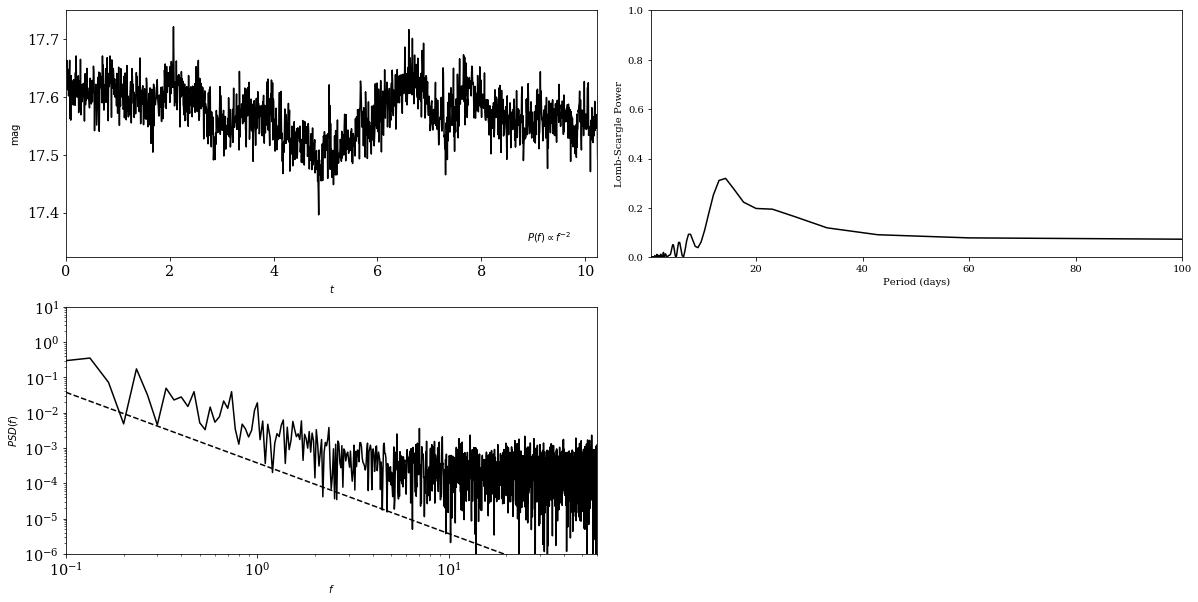

In [52]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.1,hspace=0.2)


# First axes: plot the time series
ax1 = fig.add_subplot(221)
ax1.plot(ts, lcsimulscalenoise, '-k')

ax1.text(0.95, 0.05, r"$P(f) \propto f^{-%i}$" % beta,
         ha='right', va='bottom', transform=ax1.transAxes)

ax1.set_xlim(0, 10.24)
#ax1.set_ylim(-1.5, 1.5)

ax1.set_xlabel(r'$t$')

# Second axes: plot the PSD
ax2 = fig.add_subplot(223 , xscale='log', yscale='log')
ax2.plot(f, PSD, '-k')
ax2.plot(f[1:], (lcsimulscalenoise.mean()*dt) ** 2 * (2 * np.pi * f[1:]) ** -beta, '--k')

ax2.set_xlim(1E-1, 60)
ax2.set_ylim(1E-6, 1E1)

ax2.set_xlabel(r'$f$')


ax1.set_ylabel(r'${\rm mag}$')
ax2.set_ylabel(r'$PSD(f)$')

#Lomb

freq, PLS = LombScargle(ts, lcsimulscalenoise, noise).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1,len(mjd))
mag_fit = LombScargle(ts, lcsimulscalenoise, noise).model(t=phase_fit / best_freq,
                                          frequency=best_freq)
# plot the periodogram

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')


#fig = plt.figure(figsize=(10, 6))

ax3 = fig.add_subplot(222)
ax3.set(xlim=(0.2, 100),
          ylim=(0, 1));
ax3.set_xlabel('Period (days)',fontsize=10)
ax3.set_ylabel('Lomb-Scargle Power')
ax3.tick_params(axis='both', which='major', labelsize=10)


ax3.plot(1./freq, PLS,color='k',ls='solid')

#plt.show()
#save iamge
#riodogram.eps', format='eps',bbox_inches = "tight")

plt.show()

# Get data points close to observation

In [53]:
newmjd = ts + mjd.min()
mjdsort = np.sort(mjd)
magsort = mag[np.argsort(mjd)]

closestarg = np.array([np.abs(i-newmjd).argmin() for i in mjdsort])


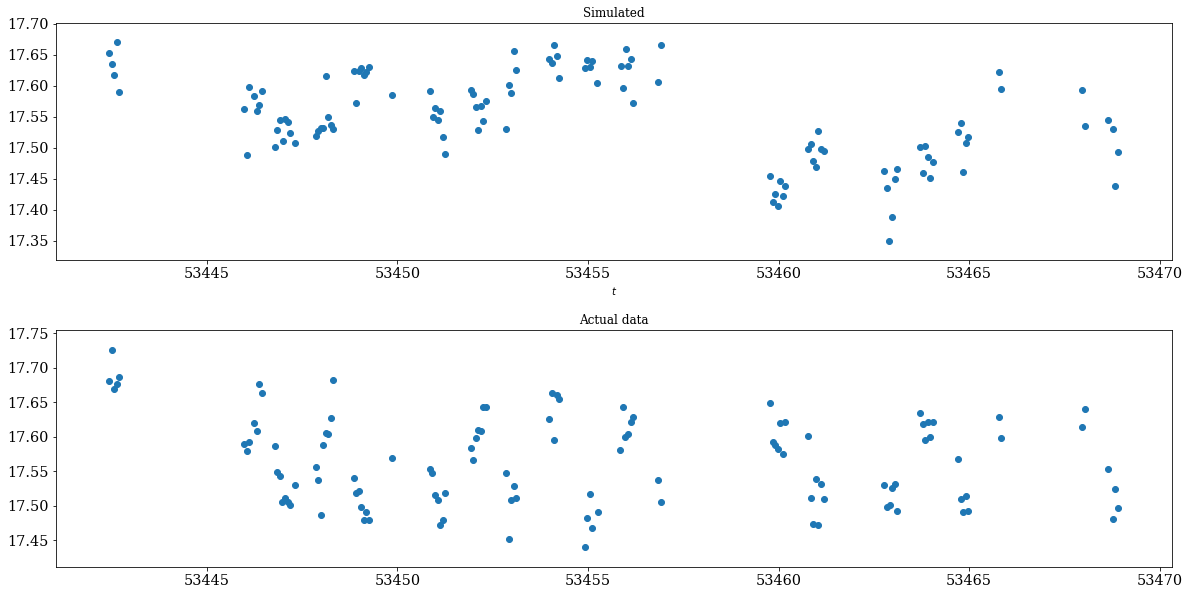

In [54]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.1,hspace=0.3)


# First axes: plot the time series
ax1 = fig.add_subplot(211)
ax1.title.set_text('Simulated')
ax1.scatter(newmjd[closestarg],lcsimulscalenoise[closestarg])


ax1.set_xlabel(r'$t$')

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.title.set_text('Actual data')

ax2.scatter(mjdsort,magsort)



closest

0.7698648009572514


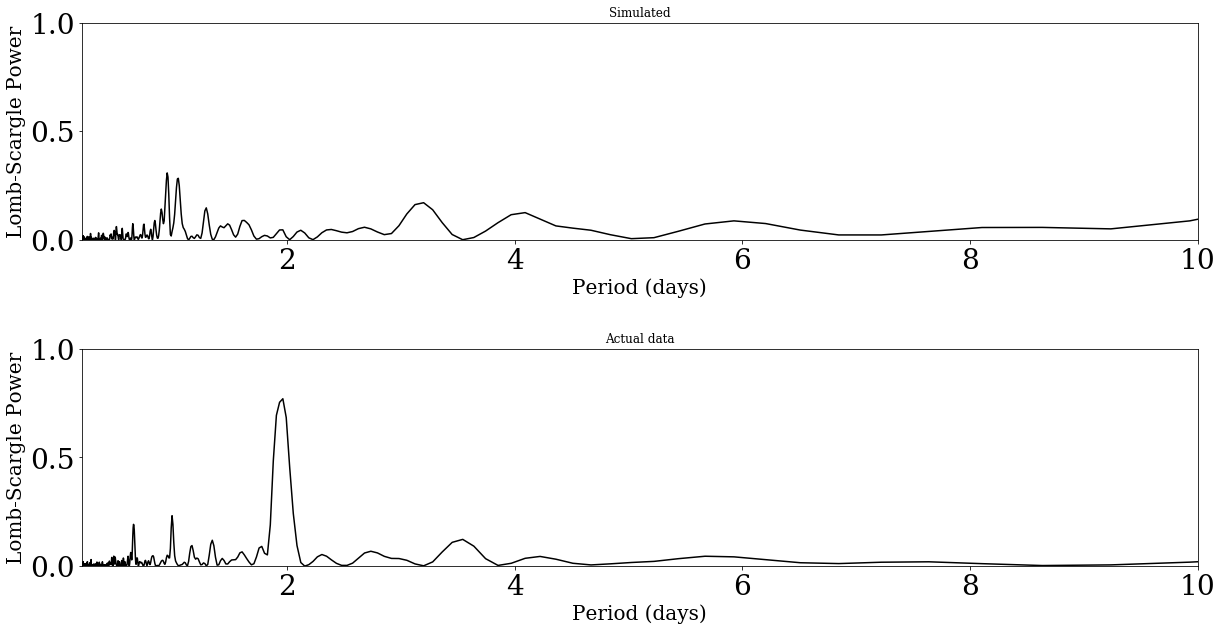

In [55]:

simulmjdclose = newmjd[closestarg]
lcsimulclose = lcsimulscalenoise[closestarg]
noiseclose = noise[closestarg]


freq, PLS = LombScargle(simulmjdclose, lcsimulclose, noiseclose).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(wspace=0.1,hspace=0.5)

# First axes: plot the time series
ax1 = fig.add_subplot(211)
ax1.title.set_text('Simulated')
ax1.set(xlim=(0.2, 10),
          ylim=(0, 1));
ax1.set_xlabel('Period (days)',fontsize=20)
ax1.set_ylabel('Lomb-Scargle Power',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=28)


ax1.plot(1./freq, PLS,color='k',ls='solid')

#save iamge
#fig.savefig('periodogram.eps', format='eps',bbox_inches = "tight")




freq, PLS = LombScargle(mjd, mag, dmag).autopower(minimum_frequency=1 / 100.,
                                                maximum_frequency=1 / 0.1)
best_freq = freq[np.argmax(PLS)]
phase = (mjd * best_freq) % 1


# plot the periodogram
print(np.max(PLS))
maxdata = np.max(PLS)


#plt.rc('font', family='serif')
#plt.rc('xtick', labelsize='x-large')
#plt.rc('ytick', labelsize='x-large')

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.title.set_text('Actual data')
ax2.set(xlim=(0.2, 10),
          ylim=(0, 1));
ax2.set_xlabel('Period (days)',fontsize=20)
ax2.set_ylabel('Lomb-Scargle Power',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=28)


ax2.plot(1./freq, PLS,color='k',ls='solid')




plt.show()


# Do it many times

In [72]:
start = tm.time()
dt = 10./60./24. # ten minutes in days
Nnumber = 30/dt # 21 days or 3 weeks
beta = 2. # red noise beta = 2

maxvals = []
bestfreqs = []
plsmax = []
plots = False
for i in np.arange(10**6):



    ts = dt * np.arange(Nnumber)


    lcsimul = generate_power_law(Nnumber,dt,beta)


    #Add Noise
    noise =  np.random.normal(size=len(lcsimul),loc=np.mean(dmag),scale=np.std(dmag))
    lcsimulnoise = lcsimul + noise


    #Scale
    #lcsimulscalenoise = np.array([(i-lcsimulnoise.mean())/lcsimulnoise.std() for i in lcsimulnoise])
    lcsimulscalenoise = stats.zscore(lcsimulnoise)
    lcsimulscalenoise = lcsimulscalenoise*mag.std()+mag.mean()

    f, PSD = PSD_continuous(ts, lcsimulscalenoise)


    #
    newmjd = ts + mjd.min()
    mjdsort = np.sort(mjd)
    magsort = mag[np.argsort(mjd)]

    closestarg = np.array([np.abs(i-newmjd).argmin() for i in mjdsort])


    simulmjdclose = newmjd[closestarg]
    lcsimulclose = lcsimulscalenoise[closestarg]
    noiseclose = noise[closestarg]


    freq, PLS = LombScargle(simulmjdclose, lcsimulclose, noiseclose).autopower(minimum_frequency=1 / 10.,
                                                    maximum_frequency=1 / 0.1)
    best_freq = freq[np.argmax(PLS)]
    phase = (mjd * best_freq) % 1

    maxvals.append(PLS.max())
    bestfreqs.append(best_freq)
    if PLS.max() > maxdata:
        plsmax.append(PLS)
    if i % 1000 == 0:
        print(i)
        print("Taken", tm.time() - start, "seconds.")
    
    if plots:

        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize='x-large')
        plt.rc('ytick', labelsize='x-large')

        fig = plt.figure(figsize=(20, 10))
        fig.subplots_adjust(wspace=0.1,hspace=0.5)

        # First axes: plot the time series
        ax1 = fig.add_subplot(211)
        ax1.title.set_text(f'Simulated Max P{PLS.max()} at {1/best_freq}')
        #ax1.set(xlim=(0.2, 10),
        #          ylim=(0, 1));
        ax1.set(ylim=(0,1));
        ax1.set_xlabel('Period (days)',fontsize=20)
        ax1.set_ylabel('Lomb-Scargle Power',fontsize=20)
        ax1.tick_params(axis='both', which='major', labelsize=28)


        ax1.plot(1./freq, PLS,color='k',ls='solid')

        #save iamge
        #fig.savefig('periodogram.eps', format='eps',bbox_inches = "tight")




        freq, PLS = LombScargle(mjd, mag, dmag).autopower(minimum_frequency=1 / 10.,
                                                        maximum_frequency=1 / 0.1)
        best_freq = freq[np.argmax(PLS)]
        phase = (mjd * best_freq) % 1


        # plot the periodogram



        plt.show()

    

0
Taken 0.023684978485107422 seconds.
1000
Taken 10.209174156188965 seconds.
2000
Taken 19.694156169891357 seconds.
3000
Taken 29.784517765045166 seconds.
4000
Taken 41.750937938690186 seconds.
5000
Taken 55.01017498970032 seconds.
6000
Taken 67.35175943374634 seconds.
7000
Taken 78.95273685455322 seconds.
8000
Taken 90.99642753601074 seconds.
9000
Taken 102.62375783920288 seconds.
10000
Taken 114.48440670967102 seconds.
11000
Taken 127.40243148803711 seconds.
12000
Taken 140.80278658866882 seconds.
13000
Taken 152.81328082084656 seconds.
14000
Taken 164.80970644950867 seconds.
15000
Taken 177.00198364257812 seconds.
16000
Taken 189.12796473503113 seconds.
17000
Taken 201.04610681533813 seconds.
18000
Taken 213.63434028625488 seconds.
19000
Taken 225.69760584831238 seconds.
20000
Taken 237.52769708633423 seconds.
21000
Taken 249.3736367225647 seconds.
22000
Taken 261.0435543060303 seconds.
23000
Taken 272.590473651886 seconds.
24000
Taken 284.76929092407227 seconds.
25000
Taken 297.316

In [73]:
len(maxvals)

1000000

In [74]:
np.max(maxvals)

0.8241019387390066

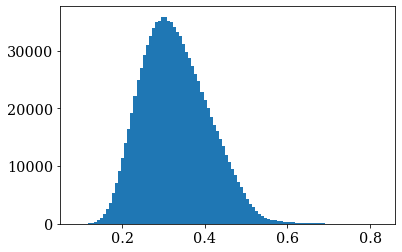

In [76]:
plt.hist(maxvals, bins = 100)
plt.show()

In [77]:
dondemas = np.where(maxvals > maxdata)

In [78]:
np.array(maxvals)[dondemas]

array([0.78750347, 0.79696524, 0.78200366, 0.81925717, 0.79414922,
       0.77033592, 0.77486065, 0.82410194, 0.7794709 , 0.80281547])

In [82]:
1/np.array(bestfreqs)[dondemas]

array([ 8.15147625, 10.        ,  8.15147625, 10.        ,  8.68673051,
       10.        , 10.        , 10.        , 10.        , 10.        ])

In [83]:
plsmax

[array([0.51636812, 0.70483008, 0.78728866, ..., 0.00409618, 0.00367785,
        0.00315476]),
 array([0.79696524, 0.65104774, 0.42415907, ..., 0.01047572, 0.01707743,
        0.01933865]),
 array([0.37220584, 0.59081168, 0.72168894, ..., 0.01535331, 0.00977224,
        0.0032905 ]),
 array([0.81925717, 0.77665122, 0.49257861, ..., 0.00174417, 0.00169907,
        0.00182458]),
 array([0.60109045, 0.74771289, 0.79414922, ..., 0.00117168, 0.00144941,
        0.00234687]),
 array([7.70335921e-01, 7.05502463e-01, 4.03743185e-01, ...,
        6.51729747e-05, 1.64177817e-03, 4.54981614e-03]),
 array([0.77486065, 0.67486048, 0.36074407, ..., 0.00975433, 0.0142761 ,
        0.014321  ]),
 array([8.24101939e-01, 7.33476659e-01, 5.42067731e-01, ...,
        7.48876440e-04, 6.66902630e-04, 3.90584912e-04]),
 array([0.7794709 , 0.65511778, 0.53756857, ..., 0.00362102, 0.00394661,
        0.00474378]),
 array([0.80281547, 0.67697222, 0.33095505, ..., 0.01559805, 0.01235526,
        0.00652803])]

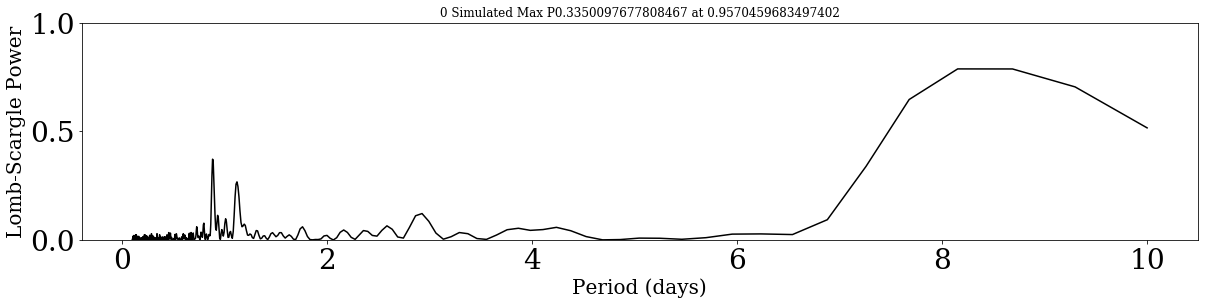

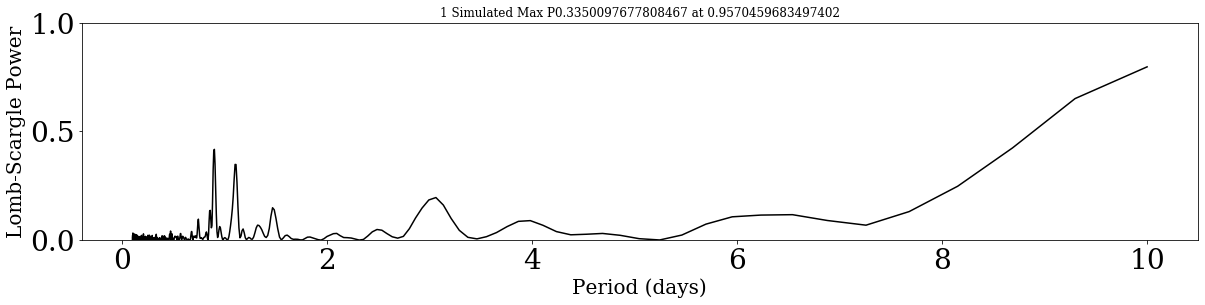

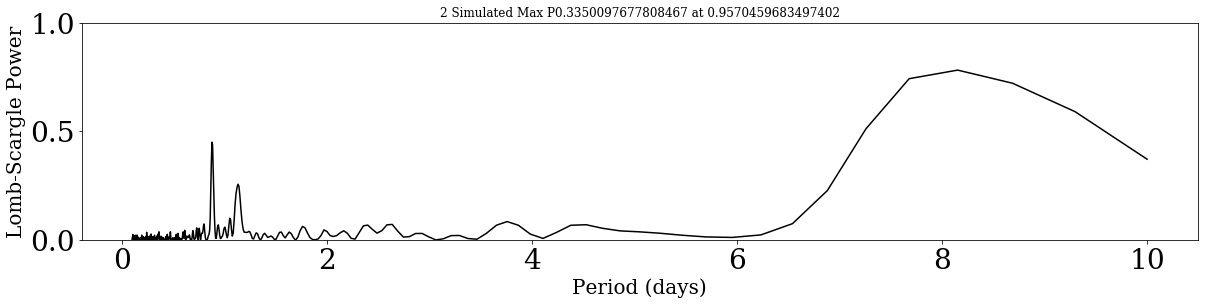

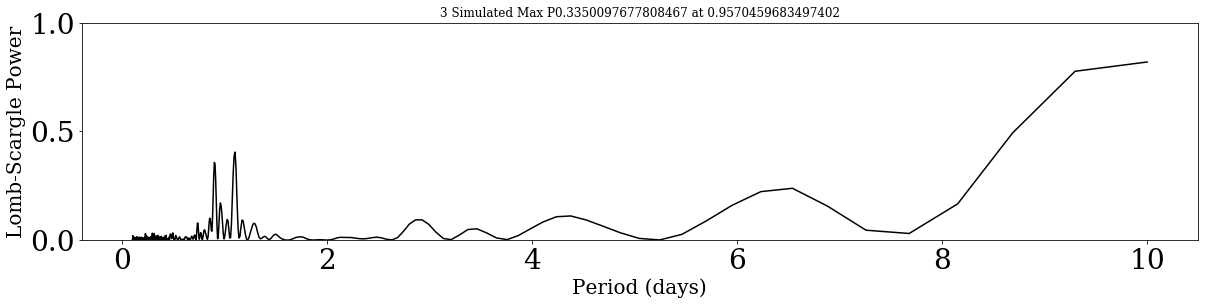

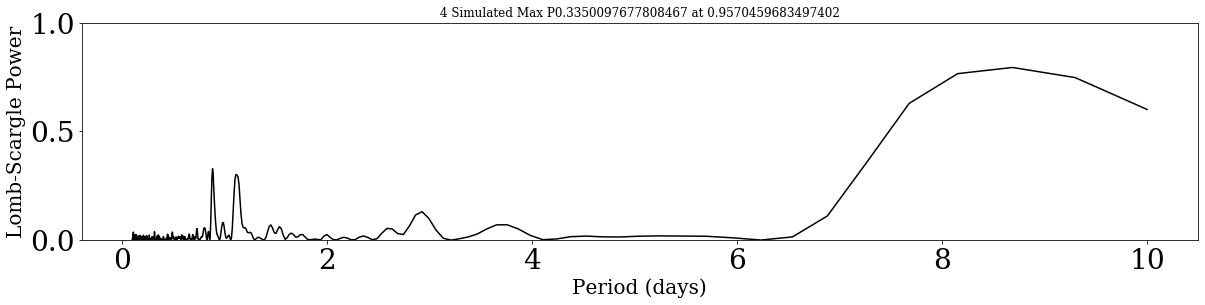

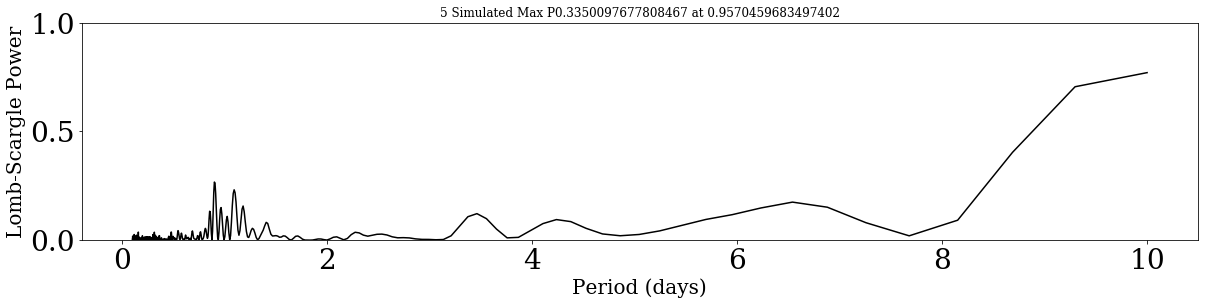

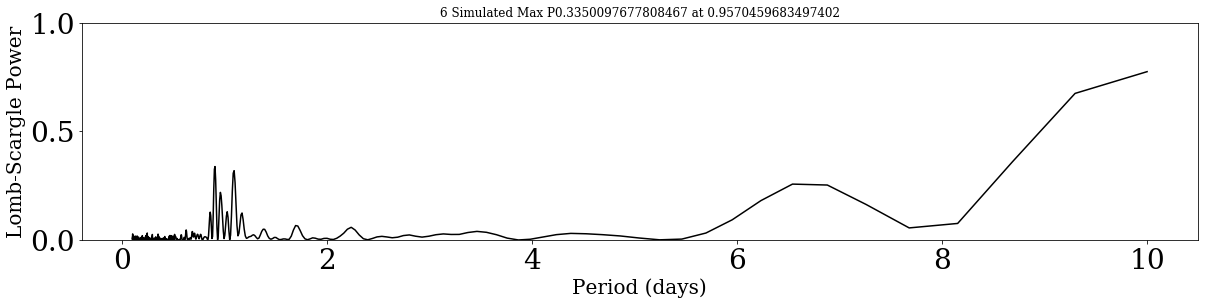

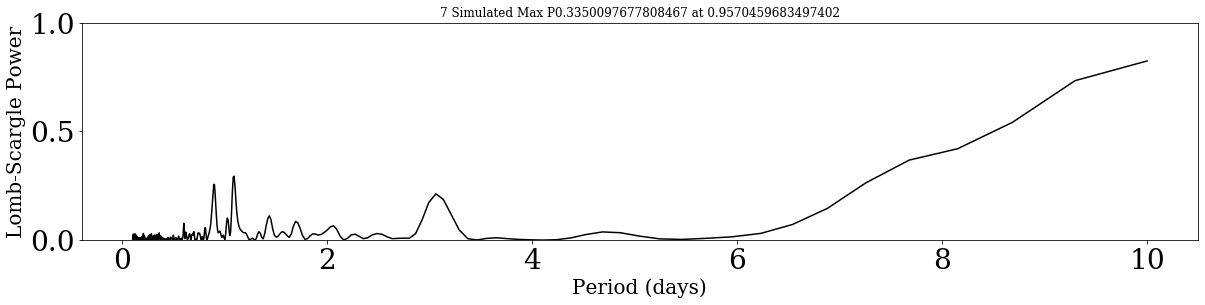

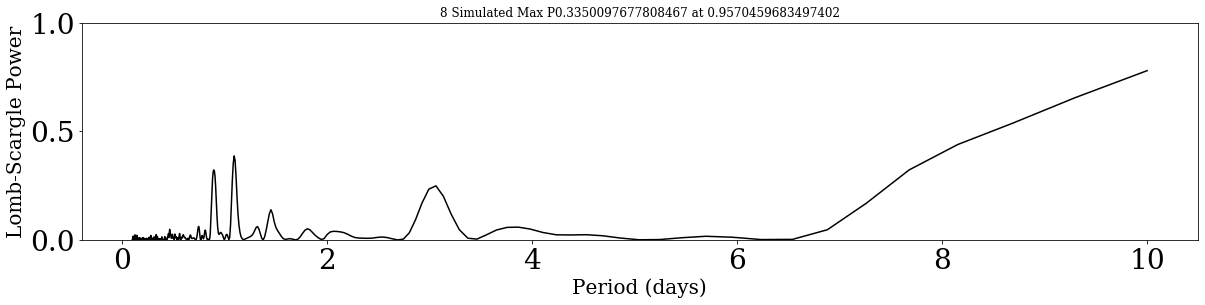

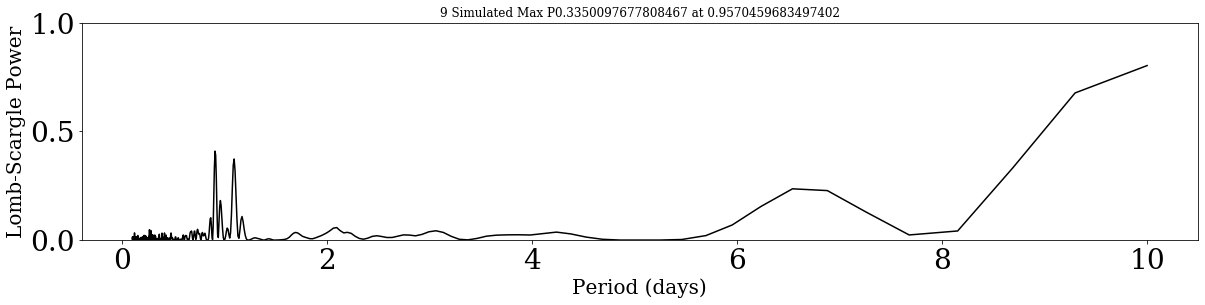

In [87]:
for j,i in enumerate(plsmax):
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize='x-large')
    plt.rc('ytick', labelsize='x-large')

    fig = plt.figure(figsize=(20, 10))
    fig.subplots_adjust(wspace=0.1,hspace=0.5)

    # First axes: plot the time series
    ax1 = fig.add_subplot(211)
    ax1.title.set_text(f'{j} Simulated Max P{PLS.max()} at {1/best_freq}')
    #ax1.set(xlim=(0.2, 10),
    #          ylim=(0, 1));
    ax1.set(ylim=(0,1));
    ax1.set_xlabel('Period (days)',fontsize=20)
    ax1.set_ylabel('Lomb-Scargle Power',fontsize=20)
    ax1.tick_params(axis='both', which='major', labelsize=28)


    ax1.plot(1./freq, i,color='k',ls='solid')

    #save iamge
    #fig.savefig('periodogram.eps', format='eps',bbox_inches = "tight")





    plt.show()


0.7698648009572514